# HW3: Tiền xử lý và mô hình hóa dữ liệu

Họ tên: Lê Thành Nam

MSSV: 18127158


---

---

---

## Import

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns # seaborn là thư viện được xây trên matplotlib, 
                      # giúp việc visualization đỡ khổ hơn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn import set_config
set_config(display='diagram') # Để trực quan hóa pipeline

# You can also import other things ...
# YOUR CODE HERE (OPTION)

---

---

## Khám phá dữ liệu (đủ để có thể xác định câu hỏi)

In [3]:
data_df = pd.read_csv('train.csv', 
                      index_col=0) # Cho cột index là cột PassengerId
data_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [4]:
data_df.shape

(891, 11)

### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Quan sát sơ bộ dữ liệu ta thấy mỗi dòng chứa thông tin của một hành khách, và có vẻ không có vấn đề các dòng có ý nghĩa khác nhau.

### Dữ liệu có các dòng bị lặp không?

In [5]:
# Số dòng bị lặp
data_df.index.duplicated().sum()

0

### Mỗi cột có ý nghĩa gì?

Xem file "description.txt".

In [6]:
with open('description.txt', 'r') as f:
    print(f.read())

VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard

---

Khám phá dữ liệu đến đây là đã đủ để có thể đưa ra câu hỏi cần trả lời. Sau khi đưa ra câu hỏi cần trả lời thì ta sẽ tiến hành ngay bước tiền xử lý là tách ra tập validation và tập kiểm tra (ở bài tập này thì chỉ tách tập validation, vì tập kiểm tra đã được Kaggle tách ra trước đó). Sau đó, ta có thể tiếp tục khám phá trên *tập huấn luyện* (tập mà đã tách ra tập validation và tập kiểm tra) để hiểu hơn về dữ liệu.

Sở dĩ ta cần *tách sớm tập validation và tập kiểm tra* vì 2 tập này (đặc biệt là tập kiểm tra) cần phải được giữ bí mật để kết quả đánh giá được khách quan. Nếu ta khám phá dữ liệu nhiều quá, hiểu dữ liệu nhiều quá rồi mới tách các tập thì kết quả trên tập validation và tập kiểm tra có thể sẽ không được khách quan vì ta có thể dùng các hiểu biết khi khám phá dữ liệu (có tập validation và tập kiểm tra trong đó) để đưa ra các lựa chọn khi tiền xử lý và mô hình hóa dữ liệu (ở đây, mình muốn nói đến các hiểu biết mà chỉ đúng với tập dữ liệu cụ thể này chứ không thật sự là đúng).

---

## Đưa ra câu hỏi cần trả lời

Quan trọng nhất ở bước này là ta phải xác định đâu là cột ouput. Về các cột input, nếu được thì ta cố gắng xác định những cột nào sẽ không dùng đến dựa vào ý nghĩa của các cột và sẽ bỏ luôn các cột này để đơn giản hóa cho các bước lúc sau (nhất là trong trường hợp dữ liệu có nhiều cột); với những cột mà không chắc chắn là nên bỏ hay nên giữ thì tạm cứ để đó, và ta sẽ làm ở bước tiền xử lý lúc sau.

Trong cuộc thi trên Kaggle với bộ dữ liệu này, cột output đã được chỉ định sẵn là cột "survival" (sống/chết). Như vậy câu hỏi cần trả lời là: 

*Output - sống/chết -* được tính từ *input - các thông tin của hành khách -* theo công thức nào?

Tạm thời ta sẽ để input là toàn bộ thông tin của hành khách, ta sẽ xác định cụ thể hơn ở bước tiền xử lý lúc sau.

Việc tìm ra câu trả lời này cho câu hỏi này thật ra không có nhiều ý nghĩa trong thực tế; mục đích chính của cuộc thi này và của bài tập này là để tập luyện tiền xử lý + mô hình hóa dữ liệu. Trong đồ án cuối kỳ thì bạn cần giải thích để người đọc thấy được ý nghĩa thực tế của việc đi tìm câu trả lời cho câu hỏi.

---

## Khám phá dữ liệu (để biết cách tách các tập)
Để biết cách tách các tập thì ta cần khám phá thêm cột output một ít:
- Cột này hiện có kiểu dữ liệu là gì? Trong bài toán hồi qui thì cột output bắt buộc phải có dạng số; nếu hiện chưa có dạng số (ví dụ, số nhưng được lưu dưới dạng chuỗi) thì ta cần chuyển sang dạng số rồi mới tách các tập.
- Cột này có giá trị thiếu không? Nếu có giá trị thiếu thì ta sẽ bỏ các dòng mà output có giá trị thiếu rồi mới tách các tập (loại học mà học từ dữ liệu trong đó output có giá trị thiếu được gọi là semi-supervised learning; trong phạm vi môn học, ta không đụng tới loại học này).
- Nếu cột này có dạng categorical (phân lớp) thì tỉ lệ các lớp như thế nào? Nếu tỉ lệ các lớp bị chênh lệch nhau quá nhiều thì có thể ta sẽ cần qua lại bước thu thập dữ liệu và thu thập thêm để cho tỉ lệ các lớp không bị chênh lệnh quá nhiều (hoặc khi đánh giá ta cần có một độ lỗi phù hợp).

In [7]:
# Cột output hiện có kiểu dữ liệu gì?
data_df['Survived'].dtype

dtype('int64')

In [8]:
# Cột output có bao nhiêu giá trị thiếu?
data_df['Survived'].isna().sum()

0

In [9]:
# Tỉ lệ các lớp trong cột output?
data_df['Survived'].value_counts(normalize=True) * 100

0    61.616162
1    38.383838
Name: Survived, dtype: float64

OK, như vậy là không có vấn đề gì cả.

---

## Tiền xử lý (tách các tập)

Bây giờ ta sẽ thực hiện bước tiền xử lý là tách tập validation và tập kiểm tra ra (trong bài tập này thì chỉ tách tập validation).

In [10]:
# Tách X và y
y_sr = data_df["Survived"] # sr là viết tắt của series
X_df = data_df.drop("Survived", axis=1)

In [11]:
# Tách tập huấn luyện và tập validation theo tỉ lệ 70%:30%
train_X_df, val_X_df, train_y_sr, val_y_sr = \
                              train_test_split(X_df, y_sr, 
                                               test_size=0.3, 
                                               stratify=y_sr, 
                                               random_state=0)

In [12]:
train_X_df.shape

(623, 10)

In [13]:
train_y_sr.shape

(623,)

In [14]:
val_X_df.shape

(268, 10)

In [15]:
val_y_sr.shape

(268,)

In [16]:
train_X_df.head().index

Int64Index([232, 837, 640, 390, 598], dtype='int64', name='PassengerId')

---

## Khám phá dữ liệu (tập huấn luyện)

Sau khi đã tách ra các tập thì ta có thể thoải mái khám phá trên tập huấn luyện mà không lo sẽ làm kết quả trên tập validation và tập kiểm tra bị mất đi sự khách quan.

### Mỗi cột input hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

In [17]:
train_X_df.dtypes

Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

Có vẻ các cột đều có kiểu dữ liệu phù hợp. 

### Với mỗi cột input có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào?

Trong `train_X_df`, có 5/10 cột có dtype không phải là object:

In [18]:
train_X_df.dtypes[train_X_df.dtypes != object]

Pclass      int64
Age       float64
SibSp       int64
Parch       int64
Fare      float64
dtype: object

Nhưng thật ra chỉ có 4 cột thật sự là dạng số: "Age", "SibSp", "Parch", "Fare". Còn cột "Pclass" thật ra là dạng categorical.

In [19]:
nume_cols = ['Age', 'SibSp', 'Parch', 'Fare']
df = train_X_df[nume_cols]
def missing_percentage(c):
    return (c.isna().mean() * 100).round(1)
def median(c):
    return c.quantile(0.5).round(1)
df.agg([missing_percentage, 'min', median, 'max'])

,Age,SibSp,Parch,Fare
missing_percentage,20.40,0.0,0.0,0.0000
min,0.42,0.0,0.0,0.0000
median,28.80,0.0,0.0,14.5000
max,80.00,8.0,5.0,512.3292


Hmm ...

### Với mỗi cột input có kiểu dữ liệu không phải dạng số, các giá trị được phân bố như thế nào?

In [20]:
pd.set_option('display.max_colwidth', 200) # Để nhìn rõ hơn
cate_cols = list(set(train_X_df.columns) - set(nume_cols))
df = train_X_df[cate_cols]
def num_values(df):
    return df.nunique()
def value_percentages(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
df.agg([missing_percentage, num_values, value_percentages])

,Cabin,Pclass,Ticket,Embarked,Name,Sex
missing_percentage,77.0,0.0,0.0,0.3,0.0,0.0
num_values,114,3,499,3,623,2
value_percentages,"{'G6': 2.1, 'B96 B98': 2.1, 'C23 C25 C27': 2.1, 'E101': 1.4, 'E121': 1.4, 'C83': 1.4, 'D35': 1.4, 'D26': 1.4, 'E24': 1.4, 'B18': 1.4, 'F33': 1.4, 'C68': 1.4, 'C52': 1.4, 'B77': 1.4, 'E8': 1.4, 'D3...","{3: 54.1, 1: 25.0, 2: 20.9}","{'347088': 1.0, '1601': 1.0, '382652': 0.8, '347082': 0.8, '4133': 0.6, 'CA. 2343': 0.6, '110152': 0.5, '371110': 0.5, '3101295': 0.5, 'PC 17572': 0.5, '349909': 0.5, 'PC 17757': 0.5, '19950': 0.5...","{'S': 73.3, 'C': 18.7, 'Q': 8.1}","{'Larsson, Mr. Bengt Edvin': 0.2, 'Fortune, Miss. Alice Elizabeth': 0.2, 'Meek, Mrs. Thomas (Annie Louise Rowley)': 0.2, 'Ostby, Mr. Engelhart Cornelius': 0.2, 'Harris, Mr. George': 0.2, 'Heininen...","{'male': 64.8, 'female': 35.2}"


Hmm ...

---

## Tiền xử lý (tập huấn luyện) (3.5đ)

Đầu tiên, ta sẽ thêm và bỏ một số cột như sau: 
- Với cột "Name", ta sẽ tiến hành rút trích ra cột "Title" tương ứng, gồm các giá trị như "Miss", "Mrs", "Mr", "Master" ..., vì trong tên thì phần này có vẻ là sẽ có ích cho việc dự đoán sống/chết. Tuy nhiên, bạn sẽ thấy "Title" có khá nhiều giá trị khác nhau trong tập huấn luyện (bạn thử thì sẽ thấy có 14 giá trị), trong đó có các giá trị chỉ xuất hiện một hoặc một ít lần; nếu ta để nguyên thì khi chuyển sang dạng số bằng phương pháp one-hot sẽ có nhiều cột &#8594; dễ bị overfit. Ta sẽ xử lý vấn đề này như sau: chỉ lấy `num_top_titles` (ví dụ, 4) giá trị xuất hiện nhiều nhất, các giá trị còn lại sẽ được thay thế bằng giá trị "Others". Lúc sau, ta sẽ thí nghiệm để chọn ra giá trị `num_top_titles` phù hợp. Sau khi xử lý cột "Title" như vừa nói, ta thêm cột này vào dataframe và bỏ cột "Name" đi.
- Bỏ cột "Cabin" vì cột này có quá nhiều giá thiếu.
- Bỏ cột "Ticket" vì cột này có rất nhiều giá trị khác nhau, nếu chuyển sang dạng số bằng phương pháp one-hot thì sẽ làm tăng số lượng cột lên rất nhiều.

Class `ColAdderDropper` ở dưới đây sẽ thực hiện các bước ở trên. Vì trong các bước ở trên, có bước ta cần tính toán các giá trị từ tập huấn luyện (`num_top_titles` giá trị của cột "Title" mà xuất hiện nhiều nhất) và dùng các giá trị này để "transform" tập dữ liệu (có thể là tập huấn luyện, có thể là tập validation hoặc tập kiểm tra) nên ta phải tự định nghĩa một class theo dạng "transformer" của Sklearn (để lúc sau có thể dùng pipeline của Sklearn) và trong đó ta phải tự định nghĩa phương thức `fit` và `transform` (còn nếu chỉ cần "transform" tập dữ liệu mà không cần tính toán giá trị gì từ tập huấn luyện thì dùng `FunctionTransformer` như trong file "08-Demo.ipynb" sẽ tiện lợi hơn). Bạn lưu ý: phương thức `fit` chỉ được dùng trên tập huấn luyện, còn phương thức `transform` (sau khi đã `fit`) có thể được dùng cho bất kỳ tập nào. Ở dưới, mình đã viết cho bạn phương thức `fit`; sau khi `fit`, các giá trị của cột "Title" cùng với số lần xuất hiện sẽ được lưu vào thuộc tính `self.title_counts_` (khi "transform" thì không cần dùng đến thông tin này, nhưng có thể bạn sẽ muốn xem thông in này), và `num_top_titles` giá trị xuất hiện nhiều nhất sẽ được lưu vào `self.top_titles_` (`num_top_titles` là siêu tham số mà phải chỉ định khi tạo ra một đối tượng thuộc class này). Nhiệm vụ của bạn là hoàn thành phương thức `transform` (trong đó, sẽ cần dùng đến `self.top_titles_`); bạn lưu ý không làm thay đổi dữ liệu ở `X_df` truyền vào.

Ngoài ra, như bạn có thể thấy ở bên dưới, class `ColAdderDropper` được kế thừa từ 2 class của Sklearn là `BaseEstimator` và `TransformerMixin`. Việc kế thừa này giúp class của ta tự động có các phương thức như `set_params`, `get_params`, `fit_transform` (nếu không thì ta sẽ phải tự định nghĩa các phương thức này). Nếu muốn tìm hiểu thêm về cách viết class theo dạng của Sklearn, bạn có thể đọc [ở đây](https://scikit-learn.org/stable/developers/develop.html?highlight=baseestimator).

In [21]:
va

In [22]:
# TEST FIT METHOD
col_adderdropper = ColAdderDropper(num_top_titles=4)
col_adderdropper.fit(train_X_df)
print(col_adderdropper.title_counts_)
print()
print(col_adderdropper.top_titles_)

Mr          357
Miss        125
Mrs          89
Master       32
Dr            7
Rev           5
Col           1
Mme           1
Countess      1
Jonkheer      1
Mlle          1
Don           1
Ms            1
Capt          1
Name: Name, dtype: int64

['Mr', 'Miss', 'Mrs', 'Master']


In [23]:
# TEST TRANSFORM METHOD
fewer_cols_train_X_df = col_adderdropper.transform(train_X_df)
assert set(fewer_cols_train_X_df.columns) == \
                                {'Age', 'Embarked', 'Fare', 'Parch', 
                                 'Pclass', 'Sex', 'SibSp', 'Title'}
assert np.all(fewer_cols_train_X_df['Title'].value_counts() == \
              pd.Series([357, 125, 89, 32, 20], 
                        ['Mr', 'Miss', 'Mrs', 'Master', 'Others']))
fewer_cols_train_X_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
232,3,male,29.0,0,0,7.7750,S,Mr
837,3,male,21.0,0,0,8.6625,S,Mr
640,3,male,NaN,1,0,16.1000,S,Mr
390,2,female,17.0,0,0,12.0000,C,Miss
598,3,male,49.0,0,0,0.0000,S,Mr


Đến đây, các cột dạng số (numerical) gồm: "Age", "SibSp", "Parch", "Fare"; các cột không phải dạng số (categorical) và không có thứ tự gồm: "Sex", "Embarked", "Title"; cột không phải dạng số và có thứ tự: "PClass". Các bước tiền xử lý tiếp theo như sau:
- Với các cột dạng số, ta sẽ điền giá trị thiếu bằng giá trị mean của cột <font color=gray>(gợi ý: dùng `SimpleImputer` trong Sklearn)</font>. Với *tất cả* các cột dạng số trong tập huấn luyện, ta đều cần tính mean, vì ta không biết được cột nào sẽ bị thiếu giá trị khi dự đoán với các véc-tơ input mới. 
- Với các cột không phải dạng số và không có thứ tự:
    - Ta sẽ điền giá trị thiếu bằng giá trị mode (giá trị xuất hiện nhiều nhất) của cột <font color=gray>(gợi ý: dùng `SimpleImputer` trong Sklearn)</font>. Với *tất cả* các cột không có dạng số và không có thứ tự, ta đều cần tính mode, vì ta không biết được cột nào sẽ bị thiếu giá trị khi dự đoán với các véc-tơ input mới.
    - Sau đó, ta sẽ chuyển sang dạng số bằng phương pháp mã hóa one-hot <font color=gray>(gợi ý: dùng `OneHotEncoder` trong Sklearn, để ý tham số `handle_unknown` vì khi dự đoán với các véc-tơ input mới ...)</font>.
- Với cột không phải dạng số và có thứ tự (cột "PClass"):
    - Ta sẽ điền giá trị thiếu bằng giá trị mode (giá trị xuất hiện nhiều nhất) của cột.
    - Cột này đã được chuyển sang dạng số rồi nên ta không cần chuyển nữa.
- Cuối cùng, khi tất cả các cột đã được điền giá trị thiếu và đã có dạng số, ta sẽ tiến hành chuẩn hóa bằng cách trừ đi mean và chia cho độ lệch chuẩn của cột để giúp cho các thuật toán cực tiểu hóa như Gradient Descent, LBFGS, ... hội tụ nhanh hơn <font color=gray>(gợi ý: dùng `StandardScaler` trong Sklearn)</font>.

Nhiệm vụ của bạn là tạo ra một pipeline, đặt tên là `preprocess_pipeline`, bao gồm: bước thêm cột `Title` và bỏ các cột (đã cài ở class `ColAdderDropper`, bạn để `num_top_titles=4`), và tất cả các bước ở đây (bạn lưu ý làm đúng theo thứ tự của các bước và các cột mà mình đã mô tả). Sau khi tạo ra được pipeline này rồi, bạn sẽ gọi phương thức `fit_transform` với đầu vào là `train_X_df` để tính các giá trị từ tập huấn luyện (ví dụ, `top_titles_` ở bước thêm và xóa cột, mean và mode ở bước xử lý giá trị thiếu, mean và độ lệch chuẩn ở bước chuẩn hóa) và đồng thời tiền xử lý `train_X_df`; kết quả trả về sẽ là `train_X_df` sau khi đã tiền xử lý, là một mảng Numpy, bạn đặt tên là `preprocessed_train_X`. <font color=gray>(Gợi ý: bạn đọc cách sử dụng pipeline ở [document](https://scikit-learn.org/stable/modules/compose.html#transforming-target-in-regression), có thể bỏ qua mục 6.1.2; bạn sẽ cần dùng `Pipeline`/`make_pipeline` và `ColumnTransformer`/`make_column_transformer`.)</font>

In [24]:

nume_cols = ['Age', 'SibSp', 'Parch', 'Fare']
unorder_cate_cols = ['Sex', 'Embarked', 'Title']
order_cate_cols = ['Pclass']

unorder_pipe = make_pipeline(SimpleImputer(missing_values = np.nan, strategy = "most_frequent"), 
                                           OneHotEncoder(handle_unknown = "ignore"))

column_trans = make_column_transformer((SimpleImputer(missing_values = np.nan, strategy = "mean"), nume_cols), 
                                      (unorder_pipe, unorder_cate_cols), 
                                      (SimpleImputer(missing_values = np.nan, strategy = "most_frequent"), order_cate_cols))
                                      
preprocess_pipeline = make_pipeline(ColAdderDropper(num_top_titles = 4), column_trans, StandardScaler())
                                      
preprocessed_train_X = preprocess_pipeline.fit_transform(train_X_df)

pd.DataFrame(preprocessed_train_X).round(3)



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.041,-0.481,-0.48,-0.479,-0.736,0.736,-0.478,-0.295,0.603,-0.233,-0.501,0.863,-0.408,-0.182,0.844
1,-0.664,-0.481,-0.48,-0.463,-0.736,0.736,-0.478,-0.295,0.603,-0.233,-0.501,0.863,-0.408,-0.182,0.844
2,0.000,0.450,-0.48,-0.325,-0.736,0.736,-0.478,-0.295,0.603,-0.233,-0.501,0.863,-0.408,-0.182,0.844
3,-0.975,-0.481,-0.48,-0.401,1.358,-1.358,2.091,-0.295,-1.659,-0.233,1.996,-1.158,-0.408,-0.182,-0.346
4,1.516,-0.481,-0.48,-0.623,-0.736,0.736,-0.478,-0.295,0.603,-0.233,-0.501,0.863,-0.408,-0.182,0.844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,-0.742,-0.481,-0.48,-0.493,-0.736,0.736,-0.478,-0.295,0.603,-0.233,-0.501,0.863,-0.408,-0.182,0.844
619,0.000,0.450,-0.48,-0.254,-0.736,0.736,-0.478,-0.295,0.603,-0.233,-0.501,0.863,-0.408,-0.182,0.844
620,0.193,-0.481,-0.48,0.422,-0.736,0.736,-0.478,-0.295,0.603,-0.233,-0.501,0.863,-0.408,-0.182,0.844
621,0.000,1.380,-0.48,-0.222,-0.736,0.736,2.091,-0.295,-1.659,-0.233,-0.501,0.863,-0.408,-0.182,0.844


In [25]:
# TEST
assert preprocessed_train_X.shape == (623, 15)
row0 = [-0.041, -0.481, -0.48, -0.479, -0.736, 0.736, -0.478, -0.295, 
        0.603, -0.233, -0.501,  0.863, -0.408, -0.182, 0.844]
row1 = [-0.664, -0.481, -0.48, -0.463, -0.736, 0.736, -0.478, -0.295, 
        0.603, -0.233, -0.501,  0.863, -0.408, -0.182, 0.844]
assert list(preprocessed_train_X[0].round(3)) == row0
assert list(preprocessed_train_X[1].round(3)) == row1
preprocess_pipeline

Pipeline(steps=[('coladderdropper', ColAdderDropper(num_top_titles=4)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer-1',
                                                  SimpleImputer(),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked', 'Title']),
                                                 ('simpleimputer-2',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Pclass'])])),
                ('standardscaler', StandardScaler())])

## Tiền xử lý (tập validation) (1.5đ)

Một khi đã có `preprocess_pipeline` với các giá trị (`top_titles_`, mean, mode, ...) đã được tính từ tập huấn luyện, ta có thể dễ dàng dùng phương thức `transform` để tiền xử lý cho các véc-tơ input mới trong tập validation và tập kiểm tra. Dưới đây, bạn sẽ làm như vậy để tiền xử lý cho `val_X_df` và lưu kết quả vào `preprocessed_val_X`.

In [26]:
# YOUR CODE HERE
preprocessed_val_X = preprocess_pipeline.transform(val_X_df)
preprocessed_val_X

array([[-0.66393269, -0.48092174, -0.47973535, ..., -0.40824829,
        -0.18211945,  0.84381575],
       [-1.98774124,  1.38003629,  0.83112046, ..., -0.40824829,
        -0.18211945, -0.34554446],
       [ 3.19068632, -0.48092174, -0.47973535, ..., -0.40824829,
        -0.18211945,  0.84381575],
       ...,
       [ 0.50413368, -0.48092174, -0.47973535, ..., -0.40824829,
        -0.18211945, -1.53490466],
       [ 0.34839149, -0.48092174, -0.47973535, ..., -0.40824829,
        -0.18211945,  0.84381575],
       [-0.19670614, -0.48092174, -0.47973535, ..., -0.40824829,
        -0.18211945, -1.53490466]])

In [27]:
# Test
assert preprocessed_val_X.shape == (268, 15)
row0 = [-0.664, -0.481, -0.48, -0.48, -0.736, 0.736, -0.478, 3.385, 
        -1.659, -0.233, -0.501,  0.863, -0.408, -0.182,  0.844]
row1 = [-1.988, 1.38, 0.831, 0.098, 1.358, -1.358, -0.478, -0.295,
        0.603, -0.233,  1.996, -1.158, -0.408, -0.182, -0.346]
assert list(preprocessed_val_X[0].round(3)) == row0
assert list(preprocessed_val_X[1].round(3)) == row1

Giải thích tại sao không nên làm 2 cách sau:
- Tiền xử lý tập validation bằng các giá trị  (top_titles_, mean, mode, ...) được tính từ tập validation
- Hoặc tiền xử lý tất cả dữ liệu rồi mới tách tập validation

YOUR ANSWER HERE

---
*Tiền xử lý tập validation bằng các giá trị(top_tittles_, mean, mode, ...) được tính từ tập validation:

*Tiền xử lý tất cả dữ liệu rồi mới tách tập validation: Ta không nên thực hiện cách này vì mục đích của việc tiền xử lý dữ liệu là rút trích và lưu lại thông tin trong tập dữ liệu hiện có để phục vụ cho việc dự đoán tương lai ở các bộ dữ liệu thực tế. Nếu ta xử lý tất cả dữ liệu theo 2 cách trên thì nghĩa là ta đã lưu giữ "thông tin tương lai" này và nó sẽ không còn giá trị dự đoán cao nữa(có thể dẫn đến overfitting khi sử dụng các thuật toán học hội tụ dữ liệu hoặc thậm chí là dự đoán sai dữ liệu). Hiện tượng này được gọi là data leakage, dùng để ám chỉ việc mô hình máy tiếp nhận kiến thức tương lai từ dữ liệu thực tế.

## Tiền xử lý + mô hình hóa

### Tìm mô hình tốt nhất (4đ)

Ta sẽ sử dụng mô hình Neural Net để phân lớp. Bạn sẽ tạo ra một pipeline từ đầu đến cuối bao gồm: các bước tiền xử lý ở trên + Neural Net (với các siêu tham số `hidden_layer_sizes=(20), activation='tanh', solver='lbfgs', random_state=0, max_iter=2500`). Bạn đặt tên cho pipeline này là `full_pipeline`. Việc tạo ra một pipeline từ đầu đến cuối như này có các lợi ích sau:
- Giúp đơn giản hóa: 
    - Để huấn luyện từ đầu tới cuối, chỉ cần gọi phương thức `fit` của pipeline này trên tập huấn luyện dạng thô. Lúc này, các "transformer" ở các bước tiền xử lý sẽ gọi `fit_transform`, còn "classifier" ở cuối sẽ gọi `fit`.
    - Với các véc-tơ input ở dạng thô, để dự đoán thì chỉ cần gọi phương thức `predict` của pipeline. Lúc này, các "transformer" ở các bước tiền xử lý sẽ gọi `transform`, còn "classifier" ở cuối sẽ gọi `predict`.
- Giúp tránh tiền xử lý tập validation/kiểm-tra sai cách (như đã nói ở mục "Tiền xử lý (tập validation)" ở trên). Để làm sai cũng khó à nha ;-).
- Giúp dễ dàng thử nghiệm đồng thời các giá trị của các siêu tham số ở các bước trong pipeline (sẽ làm ở ngay dưới).

Sau khi đã có được pipeline từ đầu đến cuối này, bạn sẽ thử nghiệm:
- Siêu tham số `alpha` (mức độ L2 regularization hay weight decay) của `MLPClassifier` với 5 giá trị khác nhau: 0.1, 1, 10, 100, 1000.
- Siêu tham số `num_top_titles` của `ColAdderDropper` (ở bước tiền xử lý) với 6 giá trị khác nhau: 1, 3, 5, 7, 9, 11.

Để gán lại giá trị `alpha` và `num_top_titles` cho `full_pipeline`, bạn sẽ dùng phương thức `set_params`: 

`full_pipeline.set_params(coladderdropper__num_top_titles=..., mlpclassifier__alpha=...)`

Trong câu lệnh ở trên, `coladderdropper` và `mlpclassifier` là tên của 2 bước trong `full_pipeline` (2 bước nào thì chắc bạn cũng đoán được). Nếu bạn tạo pipeline bằng `make_pipeline` thì tên của các bước sẽ được tự động lấy là tên của các class và được viết thường như 2 tên ở trên. Còn nếu bạn dùng `Pipeline` và tự đặt tên cho các bước thì bạn dùng tên của bạn trong phương thức `set_params`.  

Như vậy, tổng cộng bạn sẽ thử nghiệm $5\times6 = 30$ mô hình khác nhau, với mỗi mô hình bạn sẽ: huấn luyện trên tập huấn luyện, tính độ lỗi (tỉ lệ bị phân lớp sai) trên tập huấn luyện và tập validation rồi `append` độ lỗi vào 2 list tương ứng là `train_errs` và `var_errs` (để dễ nhìn, bạn tính độ lỗi theo đơn vị %, nghĩa là có giá trị từ 0-100 chứ không phải từ 0-1). Bạn lưu lại độ lỗi nhỏ nhất trên tập validation và giá trị `alpha` và `num_top_titles` tương ứng lần lượt vào biến `best_val_err`, `best_alpha`, `best_num_top_titles`.

In [28]:
# Tạo full pipeline
nume_cols = ['Age', 'SibSp', 'Parch', 'Fare']
unorder_cate_cols = ['Sex', 'Embarked', 'Title']
order_cate_cols = ['Pclass']
unorder_pipe = make_pipeline(SimpleImputer(missing_values = np.nan, strategy = "most_frequent"), 
                                           OneHotEncoder(handle_unknown = "ignore"))

column_trans = make_column_transformer((SimpleImputer(missing_values = np.nan, strategy = "mean"), nume_cols), 
                                      (unorder_pipe, unorder_cate_cols), 
                                      (SimpleImputer(missing_values = np.nan, strategy = "most_frequent"), order_cate_cols))
                                      
full_pipeline = make_pipeline(ColAdderDropper(num_top_titles = 0), 
                              column_trans, 
                              StandardScaler(), 
            MLPClassifier(hidden_layer_sizes=(20), activation='tanh', solver='lbfgs', random_state=0, max_iter=2500))

# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
alphas = [0.1, 1, 10, 100, 1000]
num_top_titles_s = [1, 3, 5, 7, 9, 11]
best_val_err = float('inf')
best_alpha = None
best_num_top_titles = None

for alpha in alphas:
    for num_top_titles in num_top_titles_s:
        
        full_pipeline.set_params(coladderdropper__num_top_titles=num_top_titles, mlpclassifier__alpha=alpha)
        full_pipeline.fit(train_X_df, train_y_sr.array)
        #Dự đoán tập huấn luyện
        predict_train = full_pipeline.predict(train_X_df)
        #Tính lỗi trên tập huấn luyện
        train_err = predict_train[predict_train != train_y_sr.array].size / predict_train.size * 100
        train_errs.append(train_err) 
        #Dự đoán tập validation
        predict_val = full_pipeline.predict(val_X_df)
        val_err = predict_val[predict_val != val_y_sr.array].size / predict_val.size * 100
        val_errs.append(val_err)
        #Tìm ra giá trị tốt nhất
        if val_err < best_val_err: 
            best_val_err = val_err
            best_num_top_titles = num_top_titles
            best_alpha = alpha


In [29]:
# TEST
full_pipeline

Pipeline(steps=[('coladderdropper', ColAdderDropper(num_top_titles=11)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer-1',
                                                  SimpleImputer(),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked', 'Title']),
                                                 ('simpleimputer-2',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Pclass'])])),
                ('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', alpha=1000,
                               hidden_layer_sizes=20, max_iter=2500,
                               random_state=0, solver='lbfgs'))])

In [30]:
# TEST
assert round(best_val_err, 3) == 16.045
assert best_alpha == 10
assert best_num_top_titles == 3

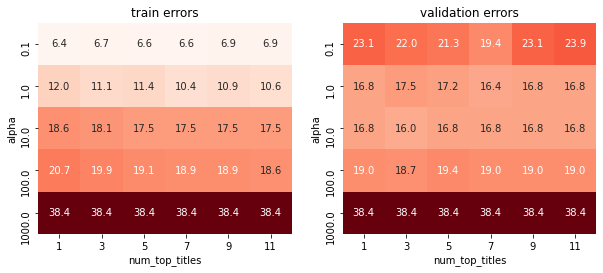

In [31]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas, columns=num_top_titles_s)
val_errs_df = pd.DataFrame(
    data=np.array(val_errs).reshape(len(alphas), -1), 
    index=alphas, columns=num_top_titles_s)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, 
            annot=True, cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('num_top_titles'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, 
            annot=True, cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('num_top_titles'); plt.ylabel('alpha');

Nhận xét về ảnh hưởng của siêu tham số `alpha` (có sao thì bạn nói vậy, chỗ nào không biết thì nói là không biết): 
- Bạn kỳ vọng khi `alpha` thay đổi thì độ lỗi trên tập huấn luyện và tập validation sẽ thay đổi như thế nào? Tại sao bạn lại kỳ vọng như vậy?
- Kết quả ở trên có giống như kỳ vọng của bạn không? Nếu không thì bạn nghĩ xem tại sao lại như vậy?

YOUR ANSWER HERE

Nhận xét về ảnh hưởng của siêu tham số `num_top_titles` (có sao thì bạn nói vậy, chỗ nào không biết thì nói là không biết): 
- Bạn kỳ vọng khi `num_top_titles` thay đổi thì độ lỗi trên tập huấn luyện và tập validation sẽ thay đổi như thế nào? Tại sao bạn lại kỳ vọng như vậy?
- Kết quả ở trên có giống như kỳ vọng của bạn không? Nếu không thì bạn nghĩ xem tại sao lại như vậy?

Theo kì vọng của em, khi tăng num_top_titles thì độ chính xác trên tập huấn luyện sẽ tăng nhưng độ chính xác trên độ validation có thể sẽ giảm(overfitting), nhưng nếu num_top_titles quá thấp thì sẽ dẫn đến underfitting. Việc này xảy ra có thể do đặc trưng Title là đặc trưng thuộc dạng biến không độc lập với dữ liệu, nó ảnh hưởng khá nhiều đến độ thay đổi của dữ liệu. 
Về tham số alpha, nếu alpha thấp thì dữ liệu sẽ hội tụ(cực tiểu độ lỗi) chậm, và nếu alpha quá cao thì dữ liệu sẽ không hội tụ được.

Cuối cùng, bạn sẽ huấn luyện lại `full_pipeline` trên `X_df` và `y_sr` (tập huấn luyện + tập validation) với `best_alpha` và `best_num_top_titles` tìm được ở trên để ra được mô hình cụ thể cuối cùng.

In [32]:
# YOUR CODE HERE
full_pipeline.set_params(coladderdropper__num_top_titles = best_num_top_titles, mlpclassifier__alpha = best_alpha)
full_pipeline.fit(X_df, y_sr)


Pipeline(steps=[('coladderdropper', ColAdderDropper(num_top_titles=3)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer-1',
                                                  SimpleImputer(),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked', 'Title']),
                                                 ('simpleimputer-2',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Pclass'])])),
                ('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', alpha=10,
                               hidden_layer_sizes=20, max_iter=2500,
                               random_state=0, solver='lbfgs'))])

### Đánh giá mô hình tìm được (1đ)
Bạn sẽ dùng mô hình cụ thể cuối cùng ở trên để dự đoán với các input trong tập test (file "test.csv") và submit kết quả dự đoán lên Kaggle. Để có thể submit thì bạn phải tạo ra file csv có 2 cột: cột thứ nhất là id của các hành khách trong tập test, cột thứ hai là giá trị dự đoán của bạn (1 - sống, và 0 - chết). Bạn có thể xem file mẫu `submission.csv` mà mình đính kèm. Bạn đặt tên file của bạn là `my_preds.csv`.

In [33]:
# YOUR CODE HERE
test = pd.read_csv('test.csv',index_col = 0)
id_col = test.index
my_preds_df = pd.DataFrame(full_pipeline.predict(test), index = id_col)
my_preds_df.columns = ['Survived']
my_preds_df.to_csv('my_preds.csv')


In [34]:
# TEST
my_preds_df = pd.read_csv('my_preds.csv', index_col=0)
assert round(my_preds_df['Survived'].mean(), 3) == 0.366
assert np.all(my_preds_df.iloc[:5].values.reshape(-1) == \
                                     np.array([0, 0, 0, 0, 1]))

Kế đến, bạn sẽ submit file csv chứa kết quả dự đoán lên [Kaggle](https://www.kaggle.com/c/titanic) (bạn sẽ cần tạo một account trên Kaggle), và ghi nhận lại độ lỗi trên tập test ở cell phía dưới (score trên Kaggle là độ chính xác).

Điểm của mô hình: 0.77751 --> Độ lỗi mô hình: 0.22249 <=> 22.25%